Before you turn this lab in, make sure everything runs as expected. **Restart and run all cells** (in the menubar, select Kernel$\rightarrow$Restart & Run All) then check the output is as expected and there are no errors.  Also remember to **Save** before uploading this file (File$\rightarrow$Save and Checkpoint).

---

# <div align="center">Quantum Computer Systems Design</div>&nbsp;  <div align="center">Lab 3</div>

### 1. Quantum Teleportation
In the videos, we constructed a circuit that can teleport any arbitrary qubit state $|\psi\rangle$, by concatenating an X-type and a Z-type swap circuit together. When Alice and Bob are long distance apart, multi-qubit gates between them are not allowed. We have to commute the forbidden CNOT in the circuit all the way to the left, as shown below:

<img src="teleport-marked.png">

The end result is that if they share a Bell state ($|\phi\rangle = |00\rangle+|11\rangle$) as resource prepared in adavance, then they can teleport $|\psi\rangle$ with only local gates and classical communications.

#### 1.1 Another teleportation circuit
Now the task consists of four steps:
1. Construct a different teleportation circuit by concatenating Z-type swap circuit first and X-type swap circuit second;
2. Commute any forbidden long-distance gates to the left and write down the resource state ($|\phi\rangle$) needed this time below, in the form of a state vector. For example, `phi = np.array([0, 1, 0, 0])` for $|\phi\rangle = |10\rangle$;
3. Implement the quantum circuit in Qiskit below.
4. (Optional) Test with at least two different initial states.

<img src="teleport-marked2.png">

##### 1.1.1 Resource state

After following steps 1 and 2 above, enter the state vector of the two-qubit state that is prepared in advance.

In [1]:
import numpy as np

# Write your quantum state here
phi = np.array([
    # YOUR CODE HERE
    np.sqrt(1/2), 0, 0, np.sqrt(1/2)
])
print(repr(phi))

array([0.70710678, 0.        , 0.        , 0.70710678])


In [2]:
# Do not delete this cell
# The autograder will test the value stored in `phi`
assert phi.shape == (4,), 'phi must be a 1D numpy array with 4 entries'
assert np.isclose(np.linalg.norm(phi), 1), (
    'The phi vector must be normalized')

##### 1.1.2 Teleporting from Alice to Bob

Construct each part of the quantum circuit in the functions below.

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.quantumregister import Qubit
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

def initial_state(qc:QuantumCircuit, a:Qubit):
    # prepare a quantum state to teleport on qubit a
    qc.ry(np.pi/8, a)

def test_by_inverse(qc, a):
    # Implements the inverse of initial_state
    qc.ry(-np.pi/8, a)

def resource_state(qc:QuantumCircuit, b:Qubit, c:Qubit):
    # Implement your resource state on qubit b and c to be distributed to alice and bob.
    # YOUR CODE HERE
    qc.h(c)
    qc.cx(c, b)

def alice(qc:QuantumCircuit, a:Qubit, b:Qubit, x:ClassicalRegister, y:ClassicalRegister):
    # Alice's quantum circuit on qubit a and b, with measurements stored to x and y.
    # YOUR CODE HERE
    qc.cx(a, b)
    qc.h(a)
    qc.measure(a, x)
    qc.z(b).c_if(x, 1)
    qc.measure(b, y)
    
def bob(qc:QuantumCircuit, c:Qubit, x:ClassicalRegister, y:ClassicalRegister):
    # Bob's quantum circuit on qubit c, and two classical bits x and y.
    # See the documentation for `c_if`
    # YOUR CODE HERE
    qc.z(c).c_if(x, 1)
    qc.x(c).c_if(y, 1)

You may test the above implementation now with the following code.

In [4]:
# You may modify (or delete) this cell or add new cells

# Initialize circuit with three qubits and two classical bits.
qreg_a = QuantumRegister(2, 'alice')
qreg_b = QuantumRegister(1, 'bob')
creg1 = ClassicalRegister(1, 'c1')
creg2 = ClassicalRegister(1, 'c2')
qc1 = QuantumCircuit(qreg_a, qreg_b, creg1, creg2)

# Run teleportation circuit
resource_state(qc1, qreg_a[1], qreg_b[0])
qc1.barrier()

initial_state(qc1, qreg_a[0])
qc1.barrier()
alice(qc1, qreg_a[0], qreg_a[1], creg1, creg2)
qc1.barrier()
bob(qc1, qreg_b[0], creg1, creg2)
qc1.barrier()

# Optionally visualize the quantum circuit
print(qc1.draw())

# Use the simulator from qiskit Aer to test
test_by_inverse(qc1, qreg_b[0]) # if successful, expect bob's qubit to return to |0> after this.
result = ClassicalRegister(1, 'verify')
qc1.add_register(result)
qc1.measure(qreg_b, result)

backend = BasicAer.get_backend('qasm_simulator')
r = execute(qc1, backend, shots=1024).result()
r.get_counts(qc1)
# Check if bob's measurement outcome is always 0.

Figure(965.016x325.08)


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'0 0 1': 271, '0 1 1': 241, '0 0 0': 239, '0 1 0': 273}

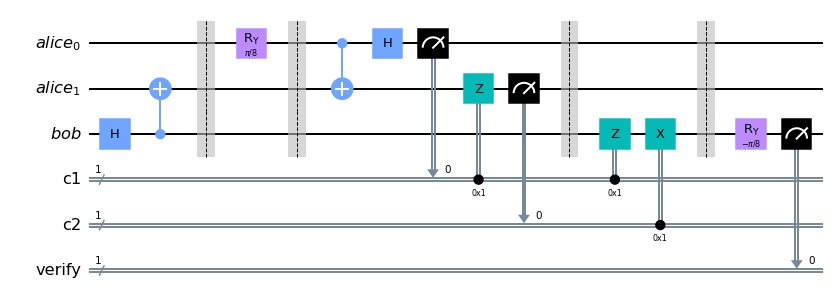

In [5]:
# (Optional)
# Your own tests
qc1.draw()

In [6]:
# Do not delete this cell
# The autograder will test the functions you implemented

# Check that you use Z-type first, then X-type
def enforce_z_first(alice):
    qreg = QuantumRegister(2, 'q')
    creg1 = ClassicalRegister(1, 'c1')
    creg2 = ClassicalRegister(1, 'c2')
    qc = QuantumCircuit(qreg, creg1, creg2)
    alice(qc, qreg[0], qreg[1], creg1, creg2)
    qc_cx = QuantumCircuit(qreg)
    qc_cx.cx(qreg[0], qreg[1])
    cx_gate, cx_qubits, _ = qc_cx[0]
    for gate, qubits, cbits in qc:
        if len(qubits) >= 2:
            # This gate must be a CNOT controlled on 0
            assert gate == cx_gate and qubits == cx_qubits, (
                f'Alice must start with `qc.cx(b, a)` but started '
                f'with {type(gate)} on {qubits}')
            break
enforce_z_first(alice)

from scipy.stats import unitary_group
from qiskit.quantum_info.operators.predicates import matrix_equal
def random_unitary(n, rng=None):
    return unitary_group.rvs(2 ** n, random_state=rng)
def equal_up_to_global_phase(m1, m2, atol=1e-8, rtol=1e-8):
    return matrix_equal(m1, m2, ignore_phase=True, atol=atol, rtol=rtol)

def test_1_1_2(alice_state_vector, rng=np.random):
    print('Testing', alice_state_vector)
    
    # Initialize circuit with three qubits and two classical bits.
    qreg_a = QuantumRegister(2, f'alice{np.random.randint(2**9)}')
    qreg_b = QuantumRegister(1, f'bob{np.random.randint(2**9)}')
    creg1 = ClassicalRegister(1, f'c1{np.random.randint(2**9)}')
    creg2 = ClassicalRegister(1, f'c2{np.random.randint(2**9)}')
    qc1 = QuantumCircuit(qreg_a, qreg_b, creg1, creg2)

    # Run teleportation circuit
    resource_state(qc1, qreg_a[1], qreg_b[0])
    qc1.barrier()
    qc1.initialize(alice_state_vector, [qreg_a[0]])
    qc1.barrier()
    alice(qc1, qreg_a[0], qreg_a[1], creg1, creg2)
    qc1.barrier()
    bob(qc1, qreg_b[0], creg1, creg2)
    qc1.barrier()
    #qc1.initialize([1, 0, 0, 0], qreg_a)
    
    # Use the simulator from qiskit Aer to test
    simulator = BasicAer.get_backend('statevector_simulator')
    r = execute(qc1, simulator, shots=1).result()
    
    # Extract just Bob's state vector
    full_state = r.get_statevector()
    bob_state = None
    for subspace in range(0, 4):
        sub_state = full_state[subspace:subspace+8:4]
        norm = np.linalg.norm(sub_state)
        if np.isclose(norm, 0): pass
        elif np.isclose(norm, 1) and bob_state is None:
            bob_state = sub_state
        else:
            print(full_state, sub_state)
            assert False, "Make sure all qubits except Bob's have been measured"
    assert bob_state is not None, "Bob's qubit state not found in state vector"
    
    # Check if bob's state equals alices initial state
    assert equal_up_to_global_phase(alice_state_vector, bob_state), (
        f"Bob's state ({bob_state}) does not match Alice's initial "
        f"state ({alice_state_vector})")

test_1_1_2([1, 0])  # |0>
test_1_1_2([0, 1])  # |1>
print('PASS')

Testing [1, 0]
Testing [0, 1]
PASS


In [7]:
# Do not delete this cell
# The autograder will continue testing the functions you implemented
test_1_1_2([0.5**0.5, 0.5**0.5])  # |+>
test_1_1_2([0.5**0.5, -0.5**0.5])  # |->
print('PASS')

Testing [0.7071067811865476, 0.7071067811865476]
Testing [0.7071067811865476, -0.7071067811865476]
PASS


In [8]:
# Do not delete this cell
# The autograder will continue testing the functions you implemented
# Hidden tests

### 2. Quantum Oracles

In this problem, we are going to explore the effect of "phase kickback" and learn to implement the different quantum oracles in practice.

#### 2.1 Phase kickback
Recall the definition of a controlled-not (CNOT) gate on qubit $a$ (control) and qubit $b$ (target): if qubit $a$ is $|0\rangle$, do nothing; if qubit $a$ is $|1\rangle$, apply X gate on qubit $b$. 

In this definition, it seems that the state of qubit $a$ will never change after the CNOT gate. Is this true? To find out, let us consider a simple scenario, where qubit $a$ and qubit $b$ are *not* entangled. 

##### 2.1.1 
What is the state of qubit $a$ after the following quantum circuit?
For example, if your answer is $\psi = \begin{pmatrix}\cos(\pi/8) \\ \sin(\pi/8)\end{pmatrix}$, enter
```python
psi211 = np.array([np.cos(np.pi/8), np.cos(np.pi/8)])
```
(This is the state after ry(π/4) on q_0.)

Note: The two qubits do not become entangled so it is possible to find the state vector for qubit $a$ independently.

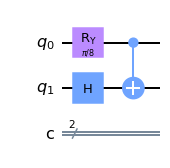

In [9]:
qc211 = QuantumCircuit(2, 2)
def prep_a(qc, a):
    qc.ry(np.pi/8, a)
    
def prep_b(qc, b):
    qc.h(b)
    
prep_a(qc211, 0)
prep_b(qc211, 1)
qc211.cx(0, 1)

qc211.draw(fold=-1)

In [10]:
psi211 = np.array([
    # YOUR CODE HERE
    np.cos(np.pi/16), np.sin(np.pi/16)
])
print(repr(psi211))

array([0.98078528, 0.19509032])


In [11]:
# Do not delete this cell
assert psi211.shape == (2,), 'psi211 must be a 1D numpy array with 2 entries'
assert np.isclose(np.linalg.norm(psi211), 1), (
    'The psi211 vector must be normalized')

##### 2.1.2 
What is the state of qubit $a$ after the following quantum circuit?
For example, if your answer is $\psi = \begin{pmatrix}\cos(\pi/8) \\ \sin(\pi/8)\end{pmatrix}$, enter
```python
psi211 = np.array([np.cos(np.pi/8), np.cos(np.pi/8)])
```
(This is the state after ry(π/4) on q_0.)

Note: The two qubits do not become entangled so it is possible to find the state vector for qubit $a$ independently.

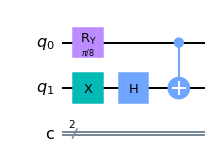

In [12]:
qc212 = QuantumCircuit(2, 2)
def prep_a2(qc, a):
    qc.ry(np.pi/8, a)
    
def prep_b2(qc, b):
    qc.x(b)
    qc.h(b)
    
prep_a2(qc212, 0)
prep_b2(qc212, 1)
qc212.cx(0, 1)

qc212.draw(fold=-1)

In [13]:
psi212 = np.array([
    # YOUR CODE HERE
    np.cos(np.pi/16), -np.sin(np.pi/16)
])
print(repr(psi212))

array([ 0.98078528, -0.19509032])


In [14]:
# Do not delete this cell
assert psi212.shape == (2,), 'psi212 must be a 1D numpy array with 2 entries'
assert np.isclose(np.linalg.norm(psi212), 1), (
    'The psi212 vector must be normalized')

##### 2.2 From "xor oracle" to "phase oracle"
Oracles play an important role in quantum query algorithms. In this problem, we are going to learn how to show that the different types of oracles in lecture are in fact equivalent, that is to show that we can simulate a phase oracle using an xor oracle.

Recall the definition of an xor oracle $O_f$ on $n$-bit input register $|x\rangle$ and $m$-bit output register $|y\rangle$, for a boolean function $f:\{0,1\}^n\rightarrow\{0,1\}^m$:

$$O_f|x,y\rangle = |x, y \oplus f(x)\rangle,$$

where $\oplus$ is the xor (addition modulo 2) operation. And similarly for a phase oracle $O_f^\pm$:

$$O_f^\pm|x,y\rangle = (-1)^{f(x)\cdot y}|x, y\rangle,$$

where $\cdot$ is the inner product.

##### 2.2.1 Implementing xor oracle
Suppose we have a function $f:\{0,1\}^5\rightarrow \{0,1\}$ which implements the parity function on input five bits, that is $f(x) = 0$ if input $x$ has even number of 1s and $f(x) = 1$ if input $x$ has odd number of 1s:

$$f(x) = x_0\oplus x_1\oplus x_2\oplus x_3\oplus x_4$$

where $x_i$ is the $i^{th}$ bit of $x$ and $\oplus$ is the xor operation. 

Write a quantum program that implements the oracle $O_f$ below.

In [15]:
def xor_oracle(qc, n, m, xreg, yreg):
    # Write your xor oracle for the function f here
    # You may assume n=5 and m=1
    # qc.z(xreg[0])
    # qc.z(xreg[1])
    # qc.z(xreg[2])
    # qc.z(xreg[3])
    # qc.z(xreg[4])
    
    qc.cx(xreg[0], yreg)
    qc.cx(xreg[1], yreg)
    qc.cx(xreg[2], yreg)
    qc.cx(xreg[3], yreg)
    qc.cx(xreg[4], yreg)

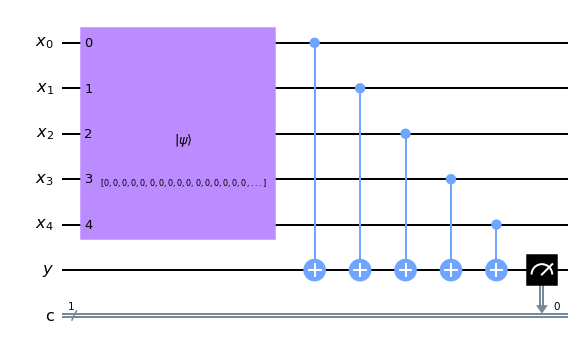

In [16]:
# You may modify (or delete) this cell or add new cells

# Initialize a circuit with five input qubits for storing x and one output qubit for y
n, m = 5, 1
xreg1 = QuantumRegister(n, 'x')
yreg1 = QuantumRegister(m, 'y')
creg1 = ClassicalRegister(m, 'c')
qc1 = QuantumCircuit(xreg1, yreg1, creg1)

# Initialize some state
x_input = 0b10011  # Change me
init_state = [0] * 2**n
init_state[x_input] = 1
qc1.initialize(init_state, xreg1)

# Apply oracle
xor_oracle(qc1, n, m, xreg1, yreg1)

# Measure output
qc1.measure(yreg1, creg1)

# Display circuit
qc1.draw(fold=-1)

In [17]:
# You may modify (or delete) this cell or add new cells

# Simulate circuit
backend = BasicAer.get_backend('qasm_simulator')
r = execute(qc1, backend, shots=1024).result()
r.get_counts(qc1)

{'1': 1024}

In [18]:
# (Optional)
# Your own tests

In [19]:
# Do not delete this cell
# The autograder will test the function `xor_oracle` you implemented

def sim_2_2_1(n, m, init_state, shots=1024):
    xreg = QuantumRegister(n, 'x')
    yreg = QuantumRegister(m, 'y')
    creg = ClassicalRegister(m, 'c')
    qc = QuantumCircuit(xreg, yreg, creg)
    # Initialize some state
    qc.initialize(init_state, xreg)
    # Apply oracle
    xor_oracle(qc, n, m, xreg, yreg)
    # Measure output
    qc.measure(yreg, creg)
    # Simulate
    backend = BasicAer.get_backend('qasm_simulator')
    r = execute(qc, backend, shots=shots).result()
    return r.get_counts(qc)

def test_2_2_1():
    # Initialize a circuit with five input qubits for storing x and one output qubit for y
    n, m = 5, 1
    # Test all classical input states
    invalid = False
    for x_input in range(2**n):
        # Simulate with each classical state
        init_state = [0] * 2**n
        init_state[x_input] = 1
        counts = sim_2_2_1(n, m, init_state)
        # Verify measured output
        if len(counts) != 1:
            invalid = True
            print(f'Invalid oracle for x={bin(x_input):<0{n+2}} '
                  f'(expected a deterministic result)')
        bit_count = 0
        for i in range(n):
            bit_count += (x_input >> i) & 1
        expected = bit_count % 2
        if int(list(counts.keys())[0], base=2) != expected:
            invalid = True
            print(f'Invalid oracle for x={bin(x_input):<0{n+2}}')
    assert not invalid, 'Invalid oracle'
test_2_2_1()
print('PASS')

PASS


In [20]:
# Do not delete this cell
# The autograder will continue testing the function `xor_oracle` you implemented
# Hidden tests

##### 2.2.2 Implementing phase oracle
Suppose now we want to use the xor oracle as subroutine to implement the phase oracle for $f$, using what we learned from phase kickback. 

Write a quantum program that implements the oracle $O_f^\pm$ below by calling your `xor_oracle` function and adding other gates before and after.

In [28]:
def phase_oracle(qc, n, m, xreg, yreg):
    # Write your phase oracle for the function f here
    # You may assume n=5 and m=1
    # qc.h(xreg[0])
    # qc.h(xreg[1])
    # qc.h(xreg[2])
    # qc.h(xreg[3])
    # qc.h(xreg[4])
    qc.x(yreg[0])
    qc.h(yreg[0])
    xor_oracle(qc, n, m, xreg, yreg)
    # qc.h(xreg[0])
    # qc.h(xreg[1])
    # qc.h(xreg[2])
    # qc.h(xreg[3])
    # qc.h(xreg[4])
    # YOUR CODE HERE

In [22]:
# (Optional)
# Your own tests

In [29]:
# Do not delete this cell
# The autograder will test the function `phase_oracle` you implemented

def sim_2_2_2(n, m, init_state):
    xreg = QuantumRegister(n, 'x')
    yreg = QuantumRegister(m, 'y')
    cxreg = ClassicalRegister(n, 'cx')
    cyreg = ClassicalRegister(n, 'cy')
    qc = QuantumCircuit(xreg, yreg, cxreg, cyreg)
    # Initialize some state
    qc.initialize(init_state, xreg)
    # Apply oracle
    phase_oracle(qc, n, m, xreg, yreg)
    # Measure output
    qc.measure(xreg, cxreg)
    qc.measure(yreg, cyreg)
    # Simulate
    backend = BasicAer.get_backend('qasm_simulator')
    r = execute(qc, backend, shots=1).result()
    return r.get_counts(qc)

def test_2_2_2():
    # Initialize a circuit with five input qubits for storing x and one output qubit for y
    n, m = 5, 1
    # Test all classical input states
    invalid = False
    for x_input in range(2**n):
        # Simulate with each classical state
        init_state = [0] * 2**n
        init_state[x_input] = 1
        counts = sim_2_2_2(n, m, init_state)
        x_meas = int(list(counts.keys())[0].split()[1], base=2)
        # Verify measured output
        if x_meas != x_input:
            invalid = True
            print(f'Invalid oracle for x={bin(x_input):<0{n+2}}')
    assert not invalid, 'Invalid oracle'
test_2_2_2()
print('PASS')

PASS


In [ ]:
# Do not delete this cell
# The autograder will continue testing the function `phase_oracle` you implemented
# Hidden tests